In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, lower
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, MapType, LongType

In [111]:
spark = SparkSession.builder.appName("JSONanalysis").getOrCreate()

In [112]:
# The below cells can be easily transposed into a UDF that takes a set of websites and used in pyspark to perform analysis
# Just need to configure spark environment to have pandas, numpy, and matplotlib, all are common packages.
# Plots can easily be saved as PNG or JPEG to be viewed, lines are left commented

In [139]:
### Update to where your websites.csv file and output is stored is stored ###
websites_path = 'C:/Users/thoma/Documents/Virginia Tech/Spring 2023/CS5614/WebCheck/data/websites.csv'
output_path = 'C:/Users/thoma/Documents/Virginia Tech/Spring 2023/CS5614/WebCheck/data/server/output'
websites = spark.read.csv(websites_path)
websites = websites.toPandas()[1:]
# websites = websites.collect()

,_c0
1,vimeo.com
2,springer.com
3,youtube.com
4,marriott.com
5,nytimes.com
6,microsoft.com
7,washingtonpost.com
8,bloomberg.com
9,bbc.com
10,thestartmagazine.com


<ipython-input-146-549d8cc39628>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=website_axis,rotation=45, ha='right')


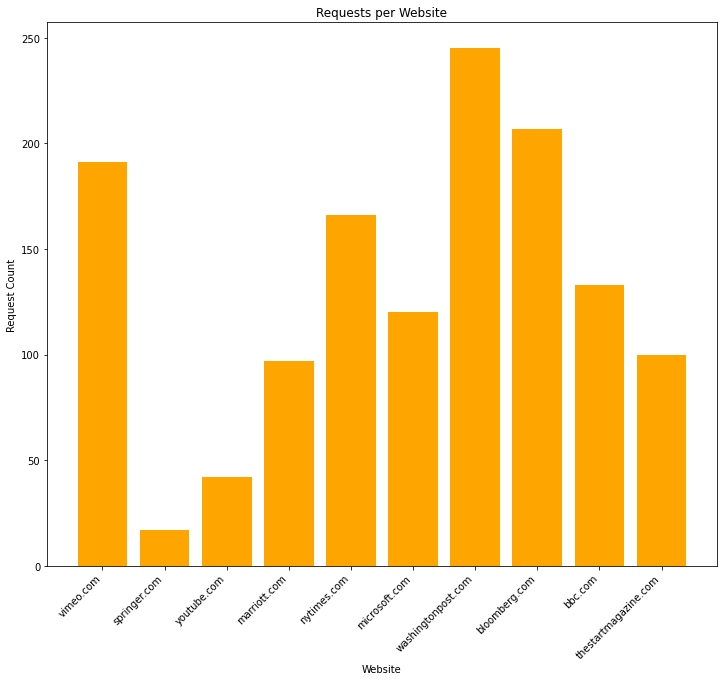

In [146]:
# Requests per website:
website_axis = []
request_count = []
for website in websites._c0:
    request_df_count = spark.read.json(f'{output_path}/{website}/request.json',multiLine=True)
    request_df_count = spark.read.json(f'{output_path}/{website}/request.json', schema=request_df_count.schema)
    request_df_count = request_df_count.toPandas()
#     request_df_count = pd.read_json(f'{output_path}/{website[0]}/request.json',lines=True)
    website_axis.append(website)
    request_count.append(len(request_df_count))

fig, ax = plt.subplots(figsize=(12,10))
ax.bar(website_axis, request_count, color='orange')
ax.set_title('Requests per Website')
ax.set_ylabel('Request Count')
ax.set_xlabel('Website')
ax.set_xticklabels(labels=website_axis,rotation=45, ha='right')
plt.savefig('request_count.png',format='png')
plt.show()

<ipython-input-147-960195c97616>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=website_axis,rotation=45, ha='right')


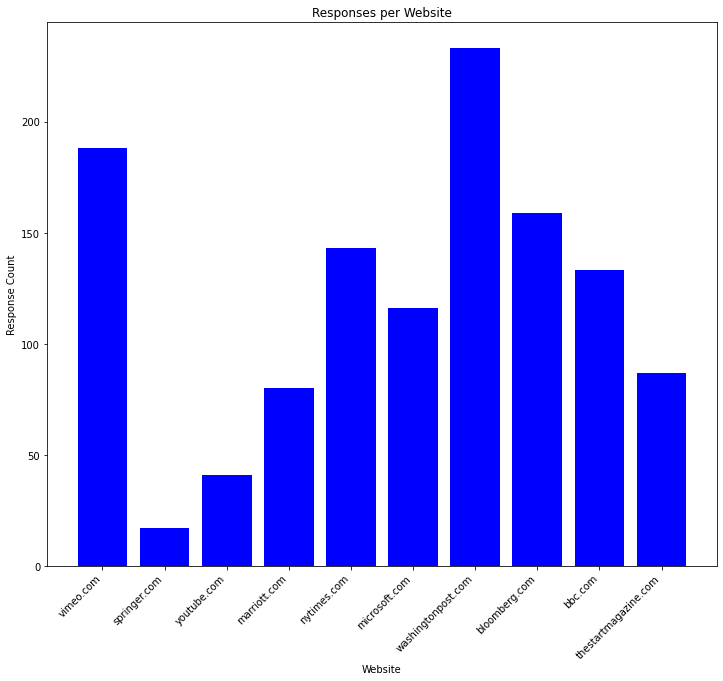

In [147]:
# Responses per website:
response_count = []

for website in websites._c0:
    response_df_count = spark.read.json(f'{output_path}/{website}/responses.json',multiLine=True)
    response_df_count = spark.read.json(f'{output_path}/{website}/responses.json', schema=response_df_count.schema)
    response_df_count = response_df_count.toPandas()
    response_count.append(len(response_df_count))

fig, ax = plt.subplots(figsize=(12,10))
ax.bar(website_axis, response_count, color='blue')
ax.set_title('Responses per Website')
ax.set_ylabel('Response Count')
ax.set_xlabel('Website')
ax.set_xticklabels(labels=website_axis,rotation=45, ha='right')
plt.savefig('response_count.png',format='png')
plt.show()

<ipython-input-152-c748811cc2a1>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=website_axis,rotation=45, ha='right')


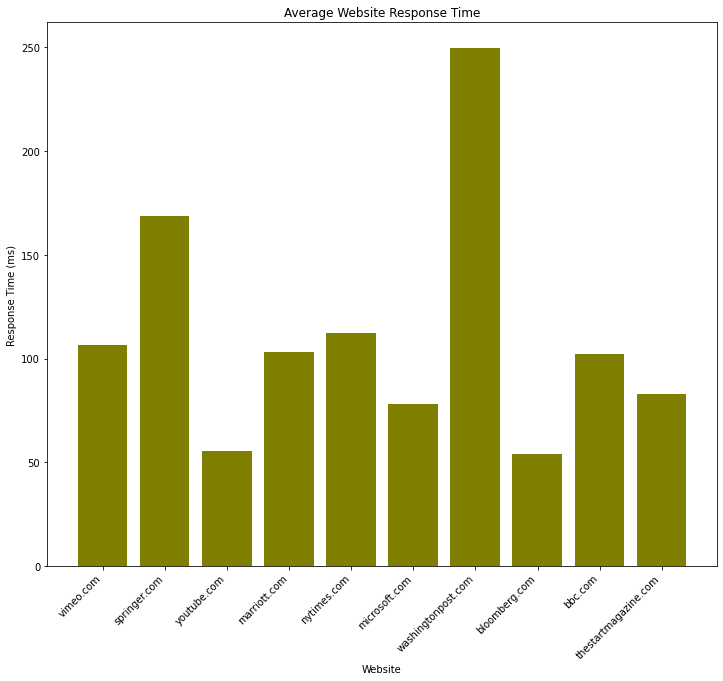

In [152]:
# Average response time per website, against all responses with timing data
# Not sure if the variable 'receiveHeadersEnd' is the correct time to go off of
# but the process remains the same and can be changed quickly
responses = []
for website in websites._c0:
    df_response = spark.read.json(f'{output_path}/{website}/responses.json',multiLine=True)
    df_response = spark.read.json(f'{output_path}/{website}/responses.json', schema=df_response.schema)
    df_response = df_response.toPandas()
    avg_response_time = 0
    count = 0
    for i in range(len(df_response.response)):
        if df_response.response.iloc[i] is None:
            continue
        if df_response.response.iloc[i].asDict().get('timing') is None:
            continue
        else:
            count+=1
            start = df_response.response.iloc[i].asDict().get('timing').asDict().get('receiveHeadersEnd')
            avg_response_time += start
    
    avg_response_time = avg_response_time/count
    responses.append(avg_response_time)
response_time_df = pd.DataFrame()
response_time_df['website'] = websites._c0
response_time_df['avg_response_time'] = np.round(responses,3)
fig, ax = plt.subplots(figsize=(12,10))
ind = np.arange(len(website_axis))
ax.bar(ind, response_time_df['avg_response_time'], color='olive')
ax.set_title('Average Website Response Time')
ax.set_ylabel('Response Time (ms)')
ax.set_xlabel('Website')
ax.set_xticklabels(labels=website_axis,rotation=45, ha='right')
ax.set_xticks(ind+0.01/2)
# for i in range(len(ind)): Adding labels to bars, does not work currently
#     ax.text(ind[i]-0.2, response_time_df['avg_response_time'][i]+1.5, str(round(response_time_df['avg_response_time'][i])))
plt.savefig('avg_response_time.png',format='png')
plt.show()

<ipython-input-180-584081ce7ba5>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=website_axis,rotation=45, ha='right')


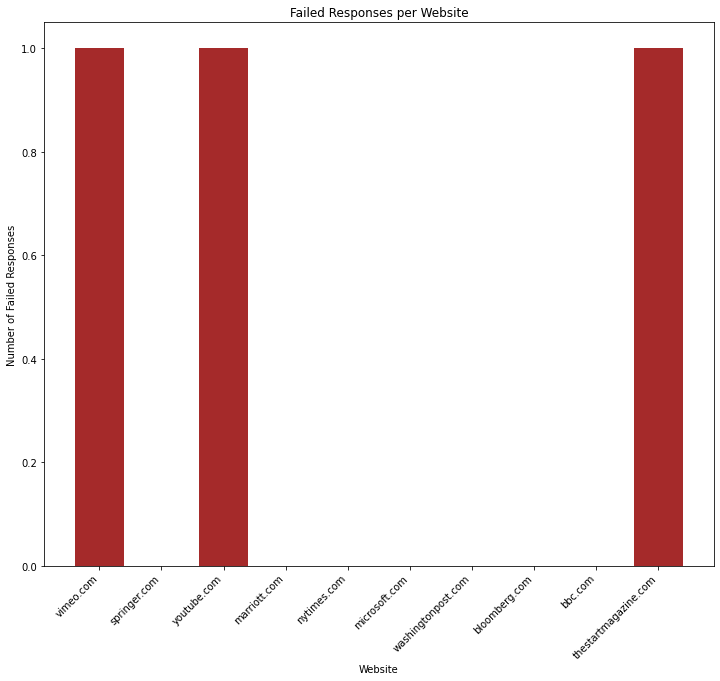

In [180]:
# Websites that returned a failed response (status code that wasnt 200)
failed_requests = []
for website in websites._c0:
    df_response = spark.read.json(f'{output_path}/{website}/responses.json',multiLine=True)
    df_response = spark.read.json(f'{output_path}/{website}/responses.json', schema=df_response.schema)
    df_response = df_response.toPandas()
    df_response = df_response.dropna()
    statuses = df_response.response.apply(lambda x: x.asDict().get('status'))
    index = statuses[statuses >= 300]
    failed_requests.append(len(index))

fig, ax = plt.subplots(figsize=(12,10))
ax.bar(website_axis, failed_requests, color='brown')
ax.set_title('Failed Responses per Website')
ax.set_ylabel('Number of Failed Responses')
ax.set_xlabel('Website')
ax.set_xticklabels(labels=website_axis,rotation=45, ha='right')
plt.savefig('failed_responses.png',format='png')
plt.show()

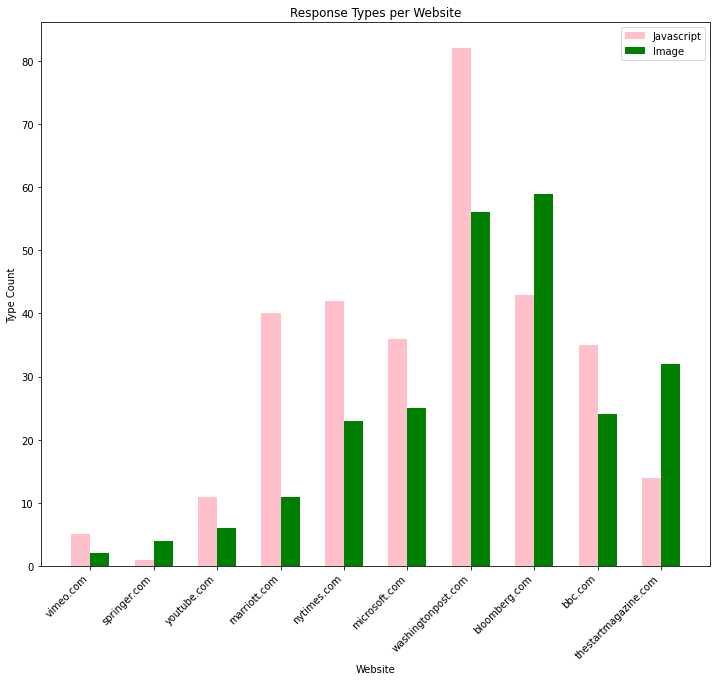

In [214]:
# Breakdown of Response Content Types per website, can be added too or modified to consider
# different content pieces
image_totals = []
jscript_totals = []
text_totals = []
for website in websites._c0:
    df_response = spark.read.json(f'{output_path}/{website}/responses.json',multiLine=True)
    df_response = spark.read.json(f'{output_path}/{website}/responses.json', schema=df_response.schema)
    df_response = df_response.toPandas()
    df_response = df_response.dropna()

    response_types = df_response.response.apply(lambda x: x.asDict().get('headers').asDict().get('content-type'))
    if website == 'vimeo.com':
        response_types = df_response.response.apply(lambda x: x.asDict().get('headers').asDict().get('Content-Type'))
    frame = {'response_type':response_types, 'total':np.ones(len(response_types))}

    df_content = pd.DataFrame(frame)
    df_content = df_content.groupby('response_type').agg({'total':'count'})
    df_content['response_type'] = df_content.index
    df_content.index = list(range(len(df_content)))
    df_content = df_content[['response_type','total']]
    df_content = df_content.rename(columns={'response_length':'avg_response_length'})
    df_content_js = df_content[df_content['response_type'].str.contains('javascript')]
    df_content_img = df_content[df_content['response_type'].str.contains('image')]
    jscript_totals.append(df_content_js['total'].sum())
    image_totals.append(df_content_img['total'].sum())

fig, ax = plt.subplots(figsize=(12,10))
ind = np.arange(len(website_axis))
ax.bar(ind, jscript_totals, 0.3, color='pink',label='Javascript')
ax.bar(ind + 0.3, image_totals, 0.3, color='green',label='Image')
ax.set_title('Response Types per Website')
ax.set_ylabel('Type Count')
ax.set_xlabel('Website')
ax.set_xticks(ind+0.3/2)
ax.set_xticklabels(labels=website_axis,rotation=45, ha='right')
ax.legend(loc='best')
plt.savefig('content_type.png',format='png')
plt.show()

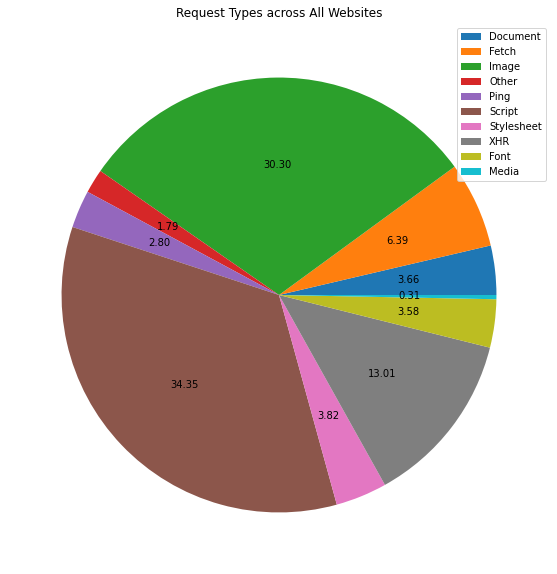

In [225]:
# Breakdown of Resource Type Per Request across all websites, most common are the Script and Image type
index_all = []
for website in websites._c0:
    df_request = spark.read.json(f'{output_path}/{website}/request.json',multiLine=True)
    df_request = spark.read.json(f'{output_path}/{website}/request.json', schema=df_request.schema)
    df_request = df_request.toPandas()
    df_request = df_request.dropna()
    
    resources = df_request.groupby('resource_type').count()
    for word in resources.index:
        if word not in index_all:
            index_all.append(word)
requesttype_master = pd.DataFrame(index = index_all)
for website in websites._c0:
    df_request = spark.read.json(f'{output_path}/{website}/request.json',multiLine=True)
    df_request = spark.read.json(f'{output_path}/{website}/request.json', schema=df_request.schema)
    df_request = df_request.toPandas()
    df_request = df_request.dropna()
    resources = df_request.groupby('resource_type').count().iloc[:,0]
    requesttype_master[f'{website}'] = resources
    
requesttype_master = requesttype_master.sum(axis=1)
requesttype_master = requesttype_master[requesttype_master > 2]
fig, ax = plt.subplots(figsize=(12,10))
ax.pie(requesttype_master, autopct='%1.2f', labeldistance=1.2)
ax.legend(labels=requesttype_master.index,loc='best')
ax.set_title('Request Types across All Websites')
plt.savefig('request_types.png',format='png')
plt.show()